In [1]:
from datasets import load_dataset

# dataset = load_dataset("disaster_response_messages")

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from torch.utils.data import random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:



# Load dataset
dataset = load_dataset("disaster_response_messages")

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

label_columns = ['related', 'PII', 'request', 'offer', 'aid_related', 'medical_help',
                 'medical_products', 'search_and_rescue', 'security', 'military',
                 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
                 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related',
                  'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops',
                 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm',
                 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']
num_lables = len(label_columns)


# Preprocessing function
def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stopwords.words('english') and word not in string.punctuation]
    return tokens

def select_columns(example):
    # Selecting the 'message' column and the last 36 columns
    selected_columns = {'message': preprocess(example['message'])}
    tmp = []
    for column in label_columns:
        tmp.append(example[column])
    selected_columns['labels']= tuple(tmp)
    return selected_columns

# Apply this function to both train and test datasets
train_data = dataset["train"].map(select_columns)
test_data = dataset["test"].map(select_columns)
validation_data = dataset["validation"].map(select_columns)

tokenizer = get_tokenizer('basic_english')


def yield_tokens(data_iter):
    for text in data_iter:
        yield text

vocab = build_vocab_from_iterator(yield_tokens(train_data['message']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

class DisasterMessagesDataset(Dataset):
    def __init__(self, data, vocab, max_len):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        message = self.data[idx]['message']
        label = self.data[idx]['labels']
        encoded_message = [vocab[token] for token in message][:self.max_len]
        padding = [0] * (self.max_len - len(encoded_message))
        return {
            'input_ids': torch.tensor(encoded_message + padding, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.float)
        }


max_len = 128  # Define maximum sequence length


# Create datasets
train_dataset = DisasterMessagesDataset(train_data, vocab, max_len)
validation_dataset = DisasterMessagesDataset(validation_data, vocab, max_len)
test_dataset = DisasterMessagesDataset(test_data, vocab, max_len)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\allan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Map:   0%|          | 0/21046 [00:00<?, ? examples/s]

Map:   0%|          | 0/2629 [00:00<?, ? examples/s]

Map:   0%|          | 0/2573 [00:00<?, ? examples/s]

In [4]:
class DisasterResponseModel(nn.Module): # LSTM
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(DisasterResponseModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout,
                            batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, sent_length]

        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, sent_len, emb dim]

        # Passing in the input and hidden state into the model and obtaining outputs
        output, (hidden, cell) = self.lstm(embedded)

        # Concat the final forward and backward hidden state
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]

        # hidden = [batch size, hid dim]
        # Pass through the fully connected layer
        dense_outputs = self.fc(hidden)

        # Final activation function softmax
        output = torch.sigmoid(dense_outputs)

        return output



In [11]:

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch['input_ids'].to(device))
        loss = criterion(predictions, batch['labels'].to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch['input_ids'].to(device))
            loss = criterion(predictions, batch['labels'].to(device))
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def accuracy(preds, y):
    # Threshold predictions at 0.5
    threshold_preds = (preds > 0.5).float()

    # Compare with labels
    correct = (threshold_preds == y).float()

    # Calculate accuracy
    acc = correct.sum() / correct.numel()
    return acc

def evaluate_with_metrics(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch['input_ids'].to(device))
            loss = criterion(predictions, batch['labels'].to(device))
            acc = accuracy(predictions, batch['labels'].to(device))

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [17]:
vocab_size = len(vocab)  # Vocabulary size
embedding_dim = 100  # Embedding dimension
hidden_dim = 256  # Hidden layer dimension
output_dim = num_lables  # Number of classes
n_layers = 2  # Number of LSTM layers
bidirectional = True  # Bidirectional LSTM
dropout = 0.5  # Dropout rate

model = DisasterResponseModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
num_epochs = 100
training_losses = []
validation_losses = []

In [18]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, validation_loader, criterion)

    training_losses.append(train_loss)
    validation_losses.append(valid_loss)
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01
	Train Loss: 10.250 | Val. Loss: 10.079
Epoch: 02
	Train Loss: 10.092 | Val. Loss: 9.979
Epoch: 03
	Train Loss: 10.017 | Val. Loss: 9.930
Epoch: 04
	Train Loss: 9.966 | Val. Loss: 9.884
Epoch: 05
	Train Loss: 9.927 | Val. Loss: 9.855
Epoch: 06
	Train Loss: 9.894 | Val. Loss: 9.838
Epoch: 07
	Train Loss: 9.868 | Val. Loss: 9.813
Epoch: 08
	Train Loss: 9.843 | Val. Loss: 9.805
Epoch: 09
	Train Loss: 9.831 | Val. Loss: 9.776
Epoch: 10
	Train Loss: 9.804 | Val. Loss: 9.778
Epoch: 11
	Train Loss: 9.790 | Val. Loss: 9.764
Epoch: 12
	Train Loss: 9.774 | Val. Loss: 9.759
Epoch: 13
	Train Loss: 9.767 | Val. Loss: 9.752
Epoch: 14
	Train Loss: 9.755 | Val. Loss: 9.747
Epoch: 15
	Train Loss: 9.741 | Val. Loss: 9.740
Epoch: 16
	Train Loss: 9.731 | Val. Loss: 9.738
Epoch: 17
	Train Loss: 9.725 | Val. Loss: 9.741
Epoch: 18
	Train Loss: 9.718 | Val. Loss: 9.726
Epoch: 19
	Train Loss: 9.714 | Val. Loss: 9.726
Epoch: 20
	Train Loss: 9.708 | Val. Loss: 9.726
Epoch: 21
	Train Loss: 9.704 | Val. 

In [19]:
valid_loss, valid_acc = evaluate_with_metrics(model, test_loader, criterion)
print(f'Test Loss: {valid_loss:.3f} | Test Accuracy: {valid_acc*100:.2f}%')

Test Loss: 9.618 | Test Accuracy: 91.70%


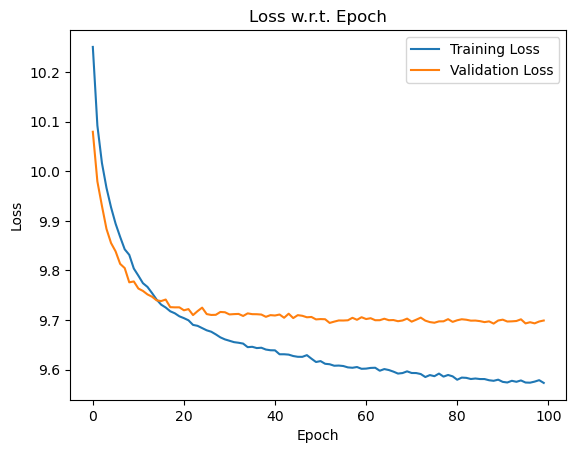

In [20]:
import matplotlib.pyplot as plt
import copy
TL = copy.deepcopy(training_losses)
VL = copy.deepcopy(validation_losses)
L = [TL,VL]
fig0 = plt.figure(0)
for i, loss in enumerate(L):
    if i == 0:
        plt.plot(loss, label='Training Loss')
    if i == 1:
        plt.plot(loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss w.r.t. Epoch')
plt.legend()
plt.show()